假设存在真实的太阳银心距（True） $R_0$, 弥散 $\tau_0$（超参数）

J 次测量得到 {$\bar{y_j}$, $\sigma_j^2$}

每次测量的真值为 $R_j$，而 $\bar{y_j}$ $\sim$ $N(R_j,\sigma_j^2)$

由贝叶斯定理，$P(R_j,R_0,\tau_0|\bar{y_j})\propto P(\bar{y_j}|R_j)P(R_j|R_0,\tau_0)P(R_0,\tau_0)$（一次观测）

很多次观测：$R=(R_1,...,R_J)$

$P(R,R_0,\tau_0|\bar{y})\propto P(R_0,\tau_0) \prod_{j=1}^J P(R_j|R_0,\tau_0) \prod_{j=1}^J P(\bar(y_j|R_j)$（后两项都是正态分布）

#### 分析：

1. 给定超参数的条件后验分布：$(R_j|R_0,\tau_0,\bar{y_j}) \sim N(\hat{R_j},V_j^2)$ 
（给定超参数情况下，问题退化成为单参数模型，相当于已知方差求均值）
（$\hat{R_j},V_j^2$的具体值见讲义P107）

2. 超参数的边缘后验分布（不关心$R_j$，只关心给定观测的情况下两个超参数的分布情况）：$P(R_0,\tau_0|\bar{y})\propto P(R_0,\tau_0) \prod_{j=1}^J P(\bar{y_j}|R_0,\sigma_i^2+\tau_0^2)$（连乘号内的P实际为正态分布）（具体得到此式的过程可见09-1视频）

3. 给定 $\tau_0$ 时 $R_0$ 的条件后验分布：$P(R_0|\tau_0,\bar{y})$，此时 $R_0|\tau_0,\bar{y}\sim N(\hat{R_0},V_R^2)$，两个参数的具体值见讲义P108

4. $\tau_0$ 的后验分布：$P(\tau_0|y)=P(R_0,\tau_0|y) / P(R_0|\tau_0,y)$（具体结果形式见讲义P108，这样计算的好处是消掉了 $R_0$，只剩下计算量以及未知的 $\tau_0$）（从这个公式回溯）

#### 计算过程：

1. 从 $P(\tau_0|y)$ 抽取 $\tau_0$ （分析4）

2. 从 $P(R_0|\tau_0,y)$ 抽取 $R_0$ （分析3）

3. 从 $P(R_j|R_0,\tau_0,y)$ 抽取 $R_j$ （分析1，主要是分析不同的观测和整体的符合情况）

In [1]:
%matplotlib inline
#posteior distribution of binomial data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits
import scipy.special as special

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# 数据输入 第一列为不同文献给出的太阳银心距，第二列是误差
# 假设所有银心距的测量误差都是正态的（不包含系统误差）
R_j = np.array([[7.9,0.75],
       [7.7,0.4],
       [8.33,0.35],
       [8.27,0.13],
       [8.92,0.56],
       [8.03,0.32],
       [8.34,0.19],
       [8.05,0.45],
       [8.08,0.62],
       [7.45,0.66],
       [8.27,0.41],
       [8.30,0.35],
       [8.70,0.50],
       [8.27,0.40],
       [8.33,0.15],
       [7.58,0.57],
       [7.50,0.60],
       [7.90,0.36],
       [7.98,0.51],
       [8.24,0.43],
       [8.60,0.81],
       [7.50,0.30],
       [8.20,0.20],
       [7.94,0.76],
       [7.40,0.28],
       [7.10,0.54]])

# prior of tau, non-informative prior used here
# tau 的先验分布，取平均分布（无信息）
def prior_tau(tau):
    return 1#/tau**2

# posterior of tao given y, in logarithmic form
# tau 的后验概率的对数形式
def lnpost_tau_y(tau, y_bar, sigma2, J):
    lnp = np.zeros(np.shape(tau))
    for i in range(len(tau)):
        inv_s2 = 1/(sigma2+tau[i]**2)
        mu_hat = np.sum(y_bar*inv_s2)/np.sum(inv_s2)
        V_mu = 1/np.sum(inv_s2)
        lnp[i] = prior_tau(tau[i])+0.5*np.log(V_mu)
        #print inv_s2,mu_hat,V_mu,lnp[i]
        # 至此，求得了 P108 (7.8) 前半部分的两个量，下面是连乘部分，在对数形式中变成累加
        if J>1:
            for j in range(J):
                lnp[i] += 0.5*np.log(inv_s2[j])-\
                    0.5*(y_bar[j]-mu_hat)**2*inv_s2[j]
        else:
            lnp[i] += 0.5*np.log(inv_s2)-\
                0.5*(y_bar-mu_hat)**2*inv_s2
        #print 0.5*np.log(inv_s2)-\
         #       0.5*(y_bar-mu_hat)**2*inv_s2
    return lnp

# 抽样得到 tau （拒绝采样）
def draw_tau(y_bar, sigma2, J, N=10000, \
             xmin=0,xmax=2,ymin=0,ymax=0.006, dy=0):
    x = []
    k = 0
    m = 0
    while k<N and m <= 3:
        x0 = np.random.uniform(low=xmin,high=xmax,size=N*20)
        y0 = np.log(np.random.uniform(low=ymin,\
                    high=ymax,size=N*20))
        y1 = lnpost_tau_y(x0,y_bar,sigma2,J)-dy
        
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        #print k,m
    xx = np.array(x).reshape((k,1))
    
    return (xx[0:N])

#draw mu from its conditional posterior given tau and y
# 抽取 R_0
def draw_condpost_mu(y_bar, sigma2, tau, N):
    mu = np.zeros(np.shape(tau))
    for i in range(N):
        inv_s2 = 1/(sigma2+tau[i]**2)
        mu_hat = np.sum(y_bar*inv_s2)/np.sum(inv_s2)
        V_mu = 1/np.sum(inv_s2)
        mu[i] = np.random.normal(mu_hat, np.sqrt(V_mu))
        # 这里求出了均值和方差，直接用正态抽样
    return mu

8.033846153846154


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


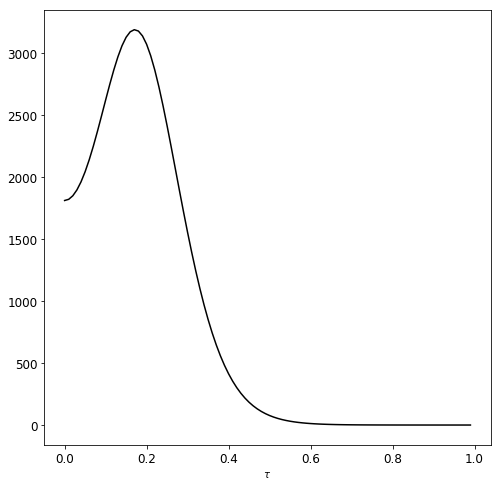

In [2]:
# random draw
# 根据公式检查分布
N = 50000
y_bar = R_j[:,0]
sigma2 = R_j[:,1]**2
J = len(R_j)
print(np.mean(y_bar))
taugrid = np.arange(0.0,1,0.01)
lnp = lnpost_tau_y(taugrid, y_bar, sigma2, J)

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.plot(taugrid,np.exp(lnp),'k-')
ax.set_xlabel(r'$\tau$')
fig.show()

In [3]:
# 抽样 tau，R0
tau_d = draw_tau(y_bar, sigma2, J, N,\
                xmin=0,xmax=1.,ymin=0,ymax=np.max(np.exp(lnp)), dy=0)
mu_d = draw_condpost_mu(y_bar, sigma2, tau_d, N)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


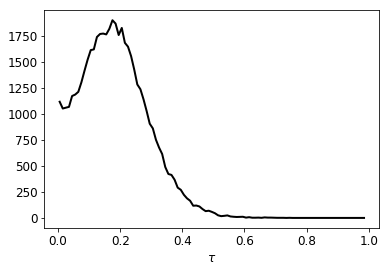

In [4]:
# draw posterior density of tau p(tau|y)
# tau的抽样结果

fig = plt.figure()
ax = fig.add_subplot(111)
taugrid = np.arange(0,1,0.01)
taucenter = (taugrid[:-1]+taugrid[1:])/2.0
htau,xedge = np.histogram(tau_d, bins=taugrid)
ax.plot(taucenter,htau,'k',linewidth=2)
ax.set_xlabel(r'$\tau$',fontsize=12)
fig.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


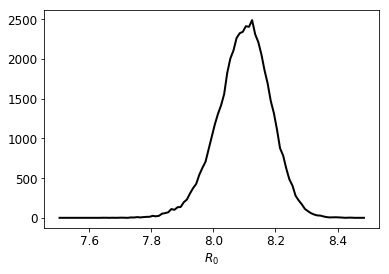

In [5]:
# draw posterior density of mu p(mu|tau,y)
# R0抽样结果

fig = plt.figure()
ax = fig.add_subplot(111)
mugrid = np.arange(7.5,8.5,0.01)
mucenter = (mugrid[:-1]+mugrid[1:])/2.0
hmu,xedge = np.histogram(mu_d, bins=mugrid)
ax.plot(mucenter,hmu,'k',linewidth=2)
ax.set_xlabel(r'$R_0$',fontsize=12)
fig.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


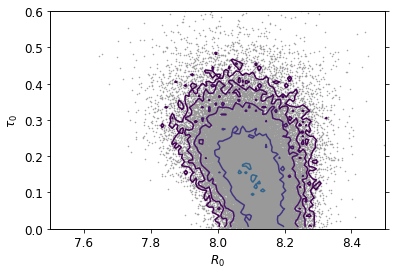

In [6]:
# draw joint posterior density of mu p(mu,tau|y)
# 联合概率分布

taugrid2 = taugrid#np.arange(0,40,0.5)
taucenter2 = (taugrid2[:-1]+taugrid2[1:])/2.0
mugrid2 = mugrid#np.arange(-30,10,0.5)
mucenter2 = (mugrid2[:-1]+mugrid2[1:])/2.0
mumesh,taumesh = np.meshgrid(mucenter2, taucenter2)
mp,xedge,ydge = np.histogram2d(mu_d.reshape((N,)), \
        tau_d.reshape((N,)), bins=[mugrid2, taugrid2])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mu_d,tau_d,'.',\
        markeredgecolor=[0.6,0.6,0.6],\
        markerfacecolor=[0.6,0.6,0.6],\
       markersize=1)
ax1 = ax.twinx()
ax1.contour(mumesh, taumesh, mp.T, \
    levels=np.array([5,10,20,50,100,150,200,300]))
ax1.set_xlim([7.5,8.5])
ax1.set_ylim([0,0.6])
ax1.set_yticklabels([])
ax.set_xlim([7.5,8.5])
ax.set_ylim([0,0.6])

ax.set_xlabel(r'$R_0$',fontsize=12)
ax.set_ylabel(r'$\tau_0$',fontsize=12)
fig.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


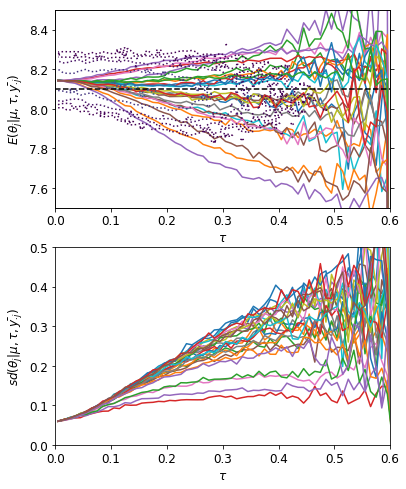

In [7]:
# sample theta_j from p(theta_j|mu,tao,y)
# 抽取 Rj （P107 7.6）

def draw_post_theta_j(mu,tau,y_bar_j,sigma2_j):
    V_j = 1/(1/sigma2_j+1/tau**2)
    theta_j_hat = (y_bar_j/sigma2_j+mu/tau**2)*V_j
    theta_j = np.random.normal(theta_j_hat, np.sqrt(V_j))
    return theta_j

#check individual samples
theta = np.zeros((J,N))
for i in range(J):
    theta[i,:] = draw_post_theta_j(\
        mu_d,tau_d,np.float(y_bar[i]),sigma2[i]).reshape((N))

E_theta = np.zeros((J,len(taucenter)))
D_theta = np.zeros((J,len(taucenter)))
for i in range(J):
    for t in range(len(taucenter)):
        ind = ((tau_d>taugrid[t]) & \
               (tau_d<=taugrid[t+1])).reshape((N,))
        if np.sum(ind)>5:
            #print np.shape(theta[i,ind.reshape((N,))])
            E_theta[i,t] = np.mean(theta[i,ind])
            D_theta[i,t] = np.sum((theta[i,ind]-\
                    E_theta[i,t])**2)/(np.sum(ind)-1)
        
taumesh,mumesh = np.meshgrid(taucenter2, mucenter2)
mp,xedge,ydge = np.histogram2d(tau_d.reshape((N,)), \
        mu_d.reshape((N,)), bins=[taugrid2, mugrid2])
fig = plt.figure(figsize=[6,8])
#mean_theta as a function of tau
ax = fig.add_subplot(211)
for i in range(J):
    ax.plot(taucenter, E_theta[i,:], '-')
ax.plot([0,10000],[np.mean(mu_d),np.mean(mu_d)],'k--')
ax1 = ax.twinx()
ax1.contour(taumesh,mumesh, mp.T, \
    levels=np.array([5,10,20,50,100,150,200,300]),\
           linestyles='dotted')
ax1.set_xlim([0,0.6])
ax1.set_ylim([7.5,8.5])
ax1.set_yticklabels([])
ax.set_xlim([0,0.6])
ax.set_ylim([7.5,8.5])
ax.set_xlabel(r'$\tau$',fontsize=12)
ax.set_ylabel(r'$E(\theta_j|\mu,\tau,\bar{y_{\cdot j}}$)',\
              fontsize=12)

ax = fig.add_subplot(212)
for i in range(J):
    ax.plot(taucenter, np.sqrt(D_theta[i,:]), '-')
ax.set_xlim([0,0.6])
ax.set_ylim([0,0.5])
ax.set_xlabel(r'$\tau$',fontsize=12)
ax.set_ylabel(r'$sd(\theta_j|\mu,\tau,\bar{y_{\cdot j}}$)',\
              fontsize=12)
fig.show()